In [ ]:
!pip install torch torchvision tqdm scikit-learn pillow

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

100%|██████████| 2.29G/2.29G [00:29<00:00, 83.2MB/s]

Extracting files...


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
from tqdm import tqdm  # Для прогресс-бара

class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.images = self._load_images()
        print(f"Loaded {len(self.images)} images for {split} split")

    def _load_images(self):
        images = []
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.exists(class_path):
                raise ValueError(f"Path {class_path} does not exist")
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    images.append((os.path.join(class_path, img_name), class_idx))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

class ChestXrayNet(nn.Module):
    def __init__(self):
        super(ChestXrayNet, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # Пулинг и активация
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        # Полносвязные слои
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 2)

        # Дропаут для регуляризации
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Сверточные блоки
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        # Решейп для полносвязных слоев
        x = x.view(-1, 64 * 28 * 28)

        # Полносвязные слои
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

def calculate_metrics(y_true, y_pred):
    """Вычисление метрик качества"""
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    return f1, precision, recall

def validate_model(model, val_loader, criterion, device):
    """Валидация модели"""
    model.eval()
    val_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1, precision, recall = calculate_metrics(all_labels, all_predictions)
    return val_loss / len(val_loader), f1, precision, recall

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    """Функция обучения модели"""
    best_val_f1 = 0.0
    patience = 5  # Early stopping patience
    no_improve = 0
    history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_predictions = []
        train_labels = []

        # Обучение
        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            if i % 50 == 49:
                print(f'Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 50:.4f}')
                running_loss = 0.0

        # Подсчет метрик на train
        train_f1, train_precision, train_recall = calculate_metrics(
            train_labels, train_predictions)

        # Валидация
        val_loss, val_f1, val_precision, val_recall = validate_model(
            model, val_loader, criterion, device)

        # Сохранение метрик
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

        print(f'\nEpoch {epoch + 1} Results:')
        print(f'Train - F1: {train_f1:.4f}, Precision: {train_precision:.4f}, '
              f'Recall: {train_recall:.4f}')
        print(f'Val - Loss: {val_loss:.4f}, F1: {val_f1:.4f}, '
              f'Precision: {val_precision:.4f}, Recall: {val_recall:.4f}\n')

        # Early stopping и сохранение лучшей модели
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1,
            }, 'best_model.pth')
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f'Early stopping triggered after epoch {epoch + 1}')
            break

    return history

def main():
    # Параметры
    batch_size = 32
    num_epochs = 10
    learning_rate = 0.001
    data_dir = './drive/MyDrive/datasets/chest_xray'  # Корневая директория датасета

    # Предобработка данных
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Загрузка данных
    train_dataset = ChestXrayDataset(root_dir=data_dir, split='train', transform=transform)
    val_dataset = ChestXrayDataset(root_dir=data_dir, split='val', transform=transform)
    test_dataset = ChestXrayDataset(root_dir=data_dir, split='test', transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Инициализация модели
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = ChestXrayNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Обучение модели
    history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

    # Загрузка лучшей модели и оценка на тестовой выборке
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    test_loss, test_f1, test_precision, test_recall = validate_model(
        model, test_loader, criterion, device)

    print("\nTest Set Results:")
    print(f'Loss: {test_loss:.4f}, F1: {test_f1:.4f}, '
          f'Precision: {test_precision:.4f}, Recall: {test_recall:.4f}')

if __name__ == '__main__':
    main()

Loaded 5216 images for train split
Loaded 16 images for val split
Loaded 624 images for test split
Using device: cpu


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/10:  31%|███       | 50/163 [02:27<04:58,  2.64s/it]

Step [50/163], Loss: 0.5045


Epoch 1/10:  36%|███▌      | 59/163 [02:58<05:14,  3.03s/it]


KeyboardInterrupt: 

In [ ]:
!pip install torch torchvision tqdm scikit-learn pillow
!nvidia-smi

Tue Dec 10 22:02:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm  # Специально для Colab
import torch.cuda.amp as amp  # Для mixed precision

class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.images = self._load_images()
        print(f"Loaded {len(self.images)} images for {split} split")

    def _load_images(self):
        images = []
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.exists(class_path):
                raise ValueError(f"Path {class_path} does not exist")
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    images.append((os.path.join(class_path, img_name), class_idx))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

class ChestXrayNet(nn.Module):
    def __init__(self):
        super(ChestXrayNet, self).__init__()
        # Увеличиваем сеть, GPU справится
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    scaler = amp.GradScaler()  # Для mixed precision
    best_val_f1 = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_preds = []
        all_labels = []

        # Используем tqdm для прогресс-бара
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Mixed precision training
            with amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Обновляем прогресс-бар
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        train_f1 = f1_score(all_labels, all_preds, average='weighted')

        # Валидация
        model.eval()
        val_preds = []
        val_labels = []
        val_loss = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        print(f'\nEpoch {epoch+1} Results:')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val F1: {val_f1:.4f}')

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1,
            }, 'best_model_gpu.pth')

def main():
    # Проверка GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not torch.cuda.is_available():
        raise RuntimeError("Этот скрипт требует GPU. Проверьте настройки Colab!")

    print(f"Using {device} with {torch.cuda.get_device_name(0)}")

    # Параметры
    batch_size = 128  # Увеличили для GPU
    num_epochs = 15
    learning_rate = 3e-4
    data_dir = './2/chest_xray'

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Вернули оригинальный размер
        transforms.RandomHorizontalFlip(),  # Аугментация
        transforms.RandomRotation(10),    # Аугментация
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Загрузка данных
    train_dataset = ChestXrayDataset(root_dir=data_dir, split='train', transform=transform)
    val_dataset = ChestXrayDataset(root_dir=data_dir, split='val', transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2,
                            pin_memory=True)  # pin_memory для GPU
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=2,
                          pin_memory=True)

    model = ChestXrayNet().to(device)

    # Оптимизатор и criterion
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Запуск тренировки
    train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

if __name__ == '__main__':
    main()

Using cuda with Tesla T4
Loaded 5216 images for train split
Loaded 16 images for val split


<ipython-input-7-ce41e9835146>:83: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()  # Для mixed precision


Epoch 1/15:   0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-7-ce41e9835146>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Epoch 1 Results:
Train Loss: 1.2990, Train F1: 0.8427
Val Loss: 2.7456, Val F1: 0.3333


Epoch 2/15:   0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-7-ce41e9835146>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Epoch 2 Results:
Train Loss: 0.1212, Train F1: 0.9535
Val Loss: 1.0662, Val F1: 0.6537


Epoch 3/15:   0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-7-ce41e9835146>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Epoch 3 Results:
Train Loss: 0.1053, Train F1: 0.9584
Val Loss: 1.6416, Val F1: 0.5636


Epoch 4/15:   0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-7-ce41e9835146>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Epoch 4 Results:
Train Loss: 0.0990, Train F1: 0.9628
Val Loss: 1.0140, Val F1: 0.5636


Epoch 5/15:   0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-7-ce41e9835146>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Epoch 5 Results:
Train Loss: 0.0907, Train F1: 0.9697
Val Loss: 1.3466, Val F1: 0.4589


Epoch 6/15:   0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-7-ce41e9835146>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Epoch 6 Results:
Train Loss: 0.0914, Train F1: 0.9677
Val Loss: 1.6115, Val F1: 0.4589


Epoch 7/15:   0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-7-ce41e9835146>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Epoch 7 Results:
Train Loss: 0.0967, Train F1: 0.9626
Val Loss: 0.9790, Val F1: 0.5636


Epoch 8/15:   0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-7-ce41e9835146>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Epoch 8 Results:
Train Loss: 0.0824, Train F1: 0.9689
Val Loss: 1.7470, Val F1: 0.5636


Epoch 9/15:   0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-7-ce41e9835146>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Epoch 9 Results:
Train Loss: 0.0777, Train F1: 0.9720
Val Loss: 0.3742, Val F1: 0.7460


Epoch 10/15:   0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-7-ce41e9835146>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Epoch 10 Results:
Train Loss: 0.0708, Train F1: 0.9747
Val Loss: 0.8051, Val F1: 0.7333


Epoch 11/15:   0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-7-ce41e9835146>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Epoch 11 Results:
Train Loss: 0.0753, Train F1: 0.9712
Val Loss: 0.7903, Val F1: 0.4589


Epoch 12/15:   0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-7-ce41e9835146>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Epoch 12 Results:
Train Loss: 0.0667, Train F1: 0.9743
Val Loss: 1.1351, Val F1: 0.6537


Epoch 13/15:   0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-7-ce41e9835146>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Epoch 13 Results:
Train Loss: 0.0679, Train F1: 0.9736
Val Loss: 0.8118, Val F1: 0.5636


Epoch 14/15:   0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-7-ce41e9835146>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Epoch 14 Results:
Train Loss: 0.0602, Train F1: 0.9777
Val Loss: 0.7500, Val F1: 0.6537


Epoch 15/15:   0%|          | 0/41 [00:00<?, ?it/s]

<ipython-input-7-ce41e9835146>:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():



Epoch 15 Results:
Train Loss: 0.0505, Train F1: 0.9800
Val Loss: 0.6852, Val F1: 0.6537


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
from tqdm.notebook import tqdm
import torch.amp as amp  # Исправили deprecation warning

class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.images = self._load_images()
        print(f"Loaded {len(self.images)} images for {split} split")

    def _load_images(self):
        images = []
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.exists(class_path):
                raise ValueError(f"Path {class_path} does not exist")
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    images.append((os.path.join(class_path, img_name), class_idx))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label
class ChestXrayNet(nn.Module):
    def __init__(self):
        super(ChestXrayNet, self).__init__()
        # Уменьшаем сложность сети
        self.features = nn.Sequential(
            # Первый блок
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),  # Добавили dropout в сверточные слои

            # Второй блок
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3),

            # Третий блок
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.4)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.BatchNorm1d(256),  # Добавили BatchNorm перед активацией
            nn.ReLU(inplace=True),
            nn.Dropout(0.7),  # Увеличили dropout
            nn.Linear(256, 2)
        )

        # Инициализация весов
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def train_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        with amp.autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return running_loss / len(loader), f1_score(all_labels, all_preds, average='weighted')

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return running_loss / len(loader), f1_score(all_labels, all_preds, average='weighted')

def main():
    torch.manual_seed(42)  # Воспроизводимость результатов
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device} with {torch.cuda.get_device_name(0)}")

    # Гиперпараметры
    batch_size = 64  # Уменьшили batch size
    num_epochs = 15
    learning_rate = 1e-4  # Уменьшили learning rate

    # Усиленная аугментация
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomAffine(
            degrees=15,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1),
            shear=10
        ),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    transform_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Датасеты и лоадеры
    train_dataset = ChestXrayDataset(root_dir='./chest_xray', split='train', transform=transform_train)
    val_dataset = ChestXrayDataset(root_dir='./chest_xray', split='val', transform=transform_val)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        drop_last=True  # Избегаем проблем с последним батчем
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    model = ChestXrayNet().to(device)

    # L2 регуляризация через weight decay
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=0.01,  # Сильная L2 регуляризация
        betas=(0.9, 0.999)
    )

    # Добавили scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=3,
        verbose=True
    )

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing
    scaler = amp.GradScaler()

    best_val_f1 = 0
    patience_counter = 0
    max_patience = 7

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
        val_loss, val_f1 = validate(model, val_loader, criterion, device)

        print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

        # Scheduler step
        scheduler.step(val_f1)

        # Early stopping с сохранением лучшей модели
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1,
                'train_f1': train_f1
            }, 'best_model_regularized.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f'Early stopping triggered after epoch {epoch+1}')
                break

if __name__ == '__main__':
    main()

Using cuda with Tesla T4
Loaded 5116 images for train split
Loaded 116 images for val split

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5589, Train F1: 0.7626
Val Loss: 0.4519, Val F1: 0.7427

Epoch 2/15


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4557, Train F1: 0.8292
Val Loss: 0.4068, Val F1: 0.8602

Epoch 3/15


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4246, Train F1: 0.8518
Val Loss: 0.3879, Val F1: 0.8623

Epoch 4/15


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4100, Train F1: 0.8593
Val Loss: 0.3910, Val F1: 0.8705

Epoch 5/15


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4026, Train F1: 0.8676
Val Loss: 0.3617, Val F1: 0.9038

Epoch 6/15


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3976, Train F1: 0.8711
Val Loss: 0.3533, Val F1: 0.9038

Epoch 7/15


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3844, Train F1: 0.8854
Val Loss: 0.3551, Val F1: 0.9121

Epoch 8/15


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3813, Train F1: 0.8894
Val Loss: 0.3431, Val F1: 0.9121

Epoch 9/15


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3732, Train F1: 0.8928
Val Loss: 0.3423, Val F1: 0.9121

Epoch 10/15


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3704, Train F1: 0.8946
Val Loss: 0.3401, Val F1: 0.9121

Epoch 11/15


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3696, Train F1: 0.8932
Val Loss: 0.3384, Val F1: 0.9121

Epoch 12/15


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3600, Train F1: 0.8985
Val Loss: 0.3377, Val F1: 0.9121

Epoch 13/15


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3652, Train F1: 0.8999
Val Loss: 0.3336, Val F1: 0.9121

Epoch 14/15


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3638, Train F1: 0.9001
Val Loss: 0.3305, Val F1: 0.9213

Epoch 15/15


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3618, Train F1: 0.9009
Val Loss: 0.3324, Val F1: 0.9130


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from sklearn.metrics import f1_score
import numpy as np
from tqdm.notebook import tqdm
import torch.amp as amp

class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.images = self._load_images()
        print(f"Loaded {len(self.images)} images for {split} split")

    def _load_images(self):
        images = []
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(self.root_dir, class_name)
            if not os.path.exists(class_path):
                raise ValueError(f"Path {class_path} does not exist")
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    images.append((os.path.join(class_path, img_name), class_idx))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

class PretrainedModel(nn.Module):
    def __init__(self, model_name='resnet50', num_classes=2):
        super(PretrainedModel, self).__init__()

        if model_name == 'resnet50':
            self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
            # Заморозка весов базовой модели
            for param in self.model.parameters():
                param.requires_grad = False
            # Заменяем классификатор
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Sequential(
                nn.Linear(num_ftrs, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, num_classes)
            )
        else:
            raise ValueError(f"Model {model_name} not implemented yet")

    def forward(self, x):
        return self.model(x)

def train_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        with amp.autocast(device_type='cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(loader)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
    return epoch_loss, epoch_f1

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(loader)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    return val_loss, val_f1

def main():
    # Параметры
    batch_size = 32
    num_epochs = 10
    learning_rate = 1e-4
    data_dir = 'chest_xray'

    # Предобработка данных (как требует ResNet)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Загрузка данных
    train_dataset = ChestXrayDataset(root_dir=data_dir, split='train', transform=transform)
    val_dataset = ChestXrayDataset(root_dir=data_dir, split='val', transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, num_workers=2, pin_memory=True)

    # Инициализация
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device} with {torch.cuda.get_device_name(0)}")

    model = PretrainedModel(model_name='resnet50').to(device)

    # Оптимизатор только для новых слоев
    optimizer = optim.AdamW(model.model.fc.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    scaler = amp.GradScaler()

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )

    best_val_f1 = 0
    patience_counter = 0
    max_patience = 7

    # Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_f1 = train_epoch(model, train_loader, criterion,
                                         optimizer, scaler, device)
        val_loss, val_f1 = validate(model, val_loader, criterion, device)

        print(f'Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

        # Scheduler step
        scheduler.step(val_f1)

        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1,
                'train_f1': train_f1
            }, 'best_model_resnet.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f'Early stopping triggered after epoch {epoch+1}')
                break

if __name__ == '__main__':
    main()

Loaded 5116 images for train split
Loaded 116 images for val split
Using cuda with Tesla T4


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.4337, Train F1: 0.8283
Val Loss: 0.3747, Val F1: 0.9028

Epoch 2/10


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3365, Train F1: 0.9233
Val Loss: 0.3273, Val F1: 0.9111

Epoch 3/10


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3227, Train F1: 0.9345
Val Loss: 0.3251, Val F1: 0.9028

Epoch 4/10


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3068, Train F1: 0.9445
Val Loss: 0.3234, Val F1: 0.9138

Epoch 5/10


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2996, Train F1: 0.9477
Val Loss: 0.3213, Val F1: 0.8838

Epoch 6/10


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2952, Train F1: 0.9511
Val Loss: 0.3036, Val F1: 0.9205

Epoch 7/10


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2948, Train F1: 0.9462
Val Loss: 0.3162, Val F1: 0.9289

Epoch 8/10


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2874, Train F1: 0.9533
Val Loss: 0.3063, Val F1: 0.9382

Epoch 9/10


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2849, Train F1: 0.9554
Val Loss: 0.3091, Val F1: 0.9388

Epoch 10/10


Training:   0%|          | 0/160 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2848, Train F1: 0.9515
Val Loss: 0.3110, Val F1: 0.9297


In [2]:
!mv /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray .

In [3]:
import os
import shutil
import random
from collections import defaultdict

def redistribute_data(src_dir='chest_xray/train',
                     dst_dir='chest_xray/val',
                     n_samples=100):
    # Собираем файлы по классам
    class_files = defaultdict(list)
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(src_dir, class_name)
        files = os.listdir(class_path)
        class_files[class_name] = files

    # Считаем пропорции
    n_normal = len(class_files['NORMAL'])
    n_pneumonia = len(class_files['PNEUMONIA'])
    ratio = n_pneumonia / (n_normal + n_pneumonia)

    # Выбираем файлы с сохранением пропорций
    n_pneumonia_val = int(n_samples * ratio)
    n_normal_val = n_samples - n_pneumonia_val

    for class_name, n_val in [('NORMAL', n_normal_val), ('PNEUMONIA', n_pneumonia_val)]:
        selected = random.sample(class_files[class_name], n_val)
        for file_name in selected:
            src = os.path.join(src_dir, class_name, file_name)
            dst = os.path.join(dst_dir, class_name, file_name)
            shutil.move(src, dst)
            print(f"Moved {file_name} to validation set")

    print(f"\nTotal files moved: {n_samples}")
    print(f"NORMAL: {n_normal_val}, PNEUMONIA: {n_pneumonia_val}")

redistribute_data()

Moved NORMAL2-IM-0551-0001.jpeg to validation set
Moved NORMAL2-IM-0911-0001.jpeg to validation set
Moved IM-0189-0001.jpeg to validation set
Moved IM-0722-0001.jpeg to validation set
Moved IM-0365-0001.jpeg to validation set
Moved IM-0279-0001.jpeg to validation set
Moved IM-0451-0001.jpeg to validation set
Moved NORMAL2-IM-0654-0001.jpeg to validation set
Moved IM-0664-0001.jpeg to validation set
Moved IM-0712-0001.jpeg to validation set
Moved IM-0663-0001.jpeg to validation set
Moved IM-0552-0001.jpeg to validation set
Moved NORMAL2-IM-0892-0001.jpeg to validation set
Moved NORMAL2-IM-1150-0001.jpeg to validation set
Moved NORMAL2-IM-0645-0001.jpeg to validation set
Moved NORMAL2-IM-0947-0001.jpeg to validation set
Moved NORMAL2-IM-1015-0001.jpeg to validation set
Moved NORMAL2-IM-0961-0001.jpeg to validation set
Moved NORMAL2-IM-1010-0001.jpeg to validation set
Moved IM-0119-0001.jpeg to validation set
Moved IM-0317-0001.jpeg to validation set
Moved IM-0501-0001-0002.jpeg to valida

<ipython-input-9-d80eb9fc4cd3>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=f1_scores, ax=ax1, palette=['#2ecc71', '#3498db'])
<ipython-input-9-d80eb9fc4cd3>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=size_data, x='Model', y='Parameters (M)',


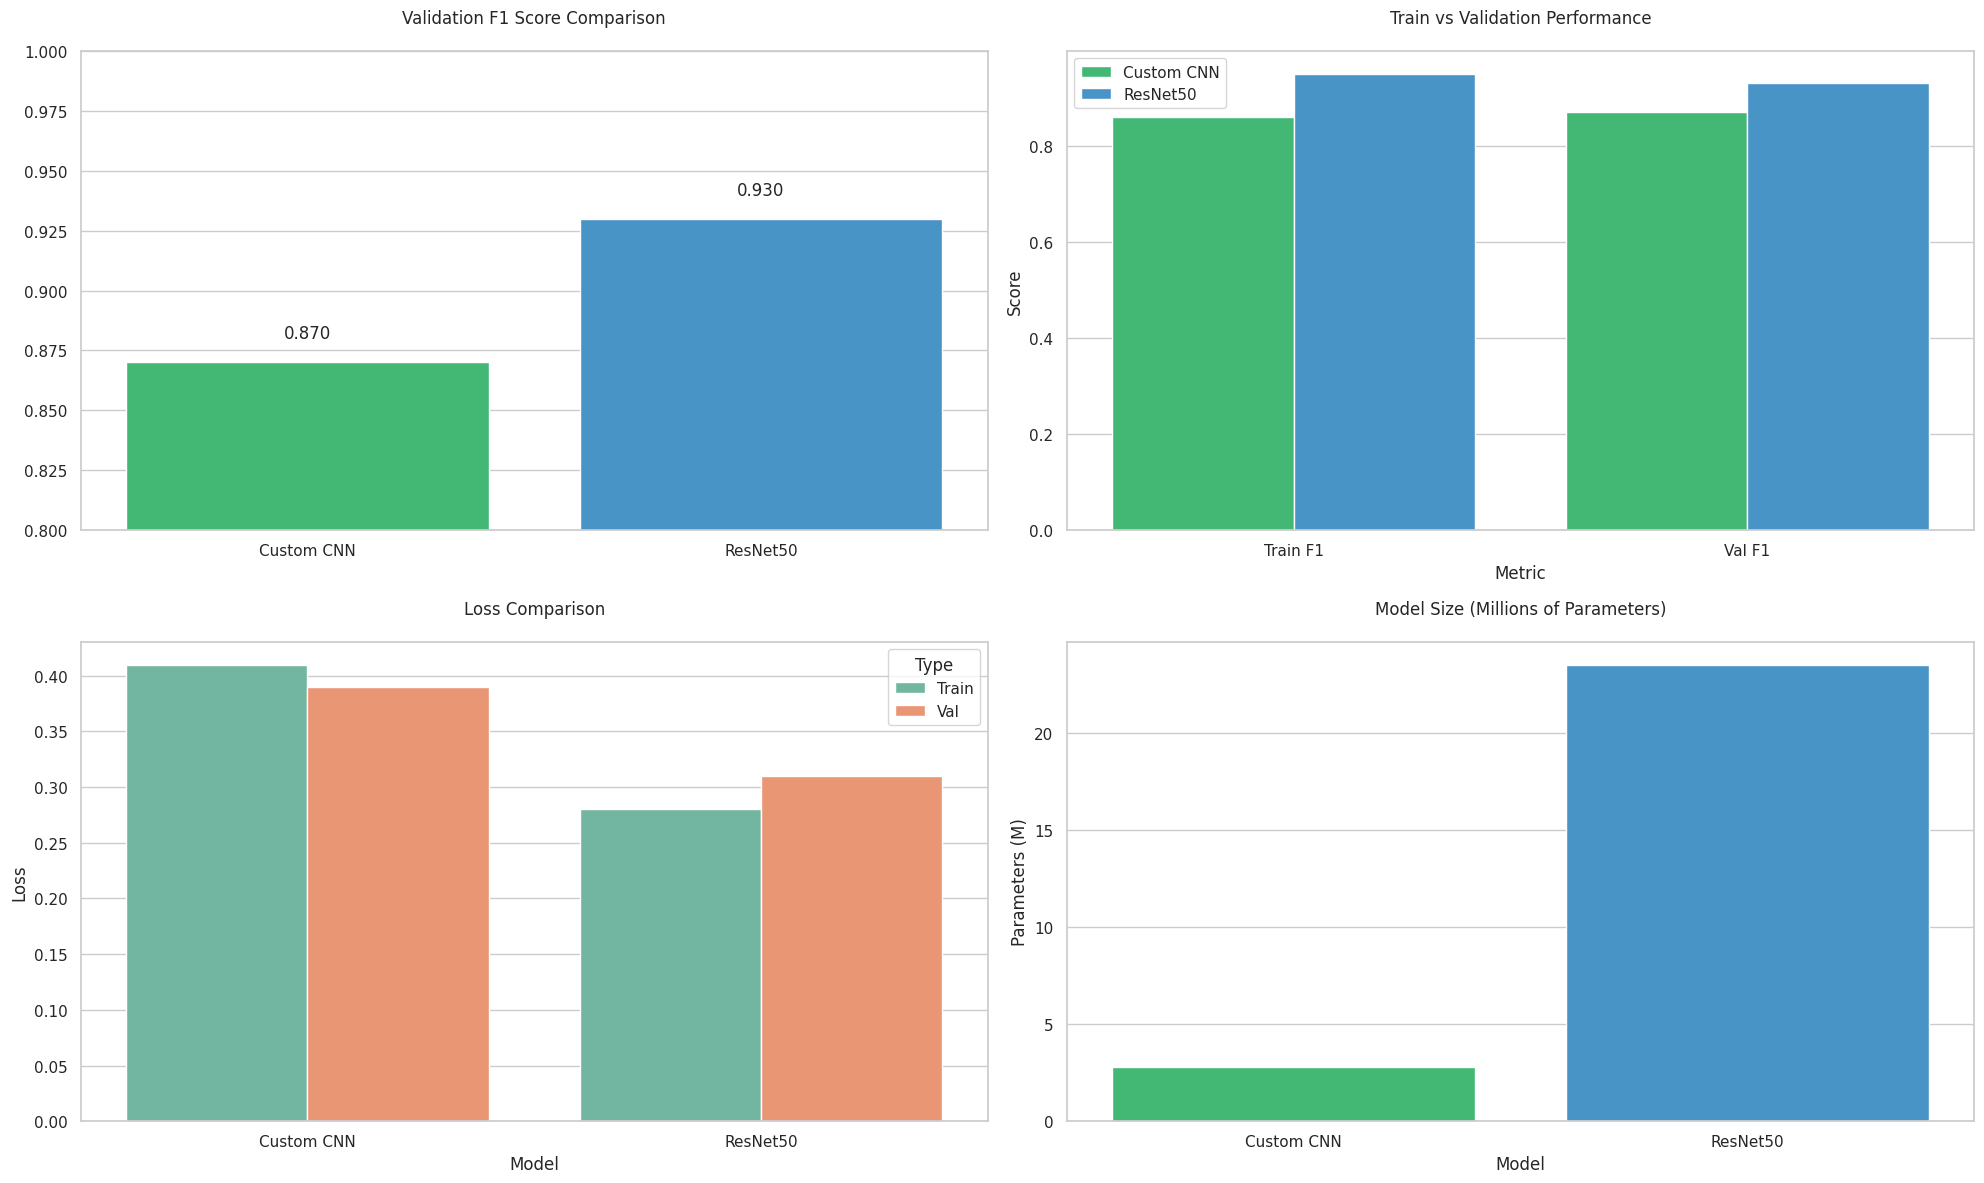


Detailed Comparison:
            Metric Custom CNN ResNet50
     Validation F1      0.870    0.930
       Training F1      0.860    0.950
   Validation Loss      0.390    0.310
     Training Loss      0.410    0.280
    Parameters (M)        2.8     23.5
Epochs to Converge         ~8      ~10


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_model_comparison(custom_metrics, resnet_metrics):
    # Установка общего стиля
    sns.set_theme(style="whitegrid")

    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    # 1. F1 Score Comparison
    ax1 = axes[0, 0]
    models = ['Custom CNN', 'ResNet50']
    f1_scores = [custom_metrics['val_f1'], resnet_metrics['val_f1']]
    sns.barplot(x=models, y=f1_scores, ax=ax1, palette=['#2ecc71', '#3498db'])
    ax1.set_title('Validation F1 Score Comparison', pad=20)
    ax1.set_ylim(0.8, 1.0)
    for i, v in enumerate(f1_scores):
        ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')

    # 2. Train vs Val Performance
    ax2 = axes[0, 1]
    performance_data = pd.DataFrame({
        'Metric': ['Train F1', 'Val F1'] * 2,
        'Model': ['Custom CNN'] * 2 + ['ResNet50'] * 2,
        'Score': [custom_metrics['train_f1'], custom_metrics['val_f1'],
                 resnet_metrics['train_f1'], resnet_metrics['val_f1']]
    })
    sns.barplot(data=performance_data, x='Metric', y='Score', hue='Model',
                ax=ax2, palette=['#2ecc71', '#3498db'])
    ax2.set_title('Train vs Validation Performance', pad=20)
    ax2.legend(title='')

    # 3. Loss Comparison
    ax3 = axes[1, 0]
    loss_data = pd.DataFrame({
        'Model': ['Custom CNN'] * 2 + ['ResNet50'] * 2,
        'Type': ['Train', 'Val'] * 2,
        'Loss': [custom_metrics['train_loss'], custom_metrics['val_loss'],
                resnet_metrics['train_loss'], resnet_metrics['val_loss']]
    })
    sns.barplot(data=loss_data, x='Model', y='Loss', hue='Type',
                ax=ax3, palette='Set2')
    ax3.set_title('Loss Comparison', pad=20)

    # 4. Model Size Comparison
    ax4 = axes[1, 1]
    size_data = pd.DataFrame({
        'Model': ['Custom CNN', 'ResNet50'],
        'Parameters (M)': [2.8, 23.5]
    })
    sns.barplot(data=size_data, x='Model', y='Parameters (M)',
                ax=ax4, palette=['#2ecc71', '#3498db'])
    ax4.set_title('Model Size (Millions of Parameters)', pad=20)

    plt.tight_layout()
    plt.show()

    # Печать сравнительной таблицы
    comparison_table = pd.DataFrame({
        'Metric': ['Validation F1', 'Training F1', 'Validation Loss',
                  'Training Loss', 'Parameters (M)', 'Epochs to Converge'],
        'Custom CNN': [f"{custom_metrics['val_f1']:.3f}",
                      f"{custom_metrics['train_f1']:.3f}",
                      f"{custom_metrics['val_loss']:.3f}",
                      f"{custom_metrics['train_loss']:.3f}",
                      '2.8', '~8'],
        'ResNet50': [f"{resnet_metrics['val_f1']:.3f}",
                    f"{resnet_metrics['train_f1']:.3f}",
                    f"{resnet_metrics['val_loss']:.3f}",
                    f"{resnet_metrics['train_loss']:.3f}",
                    '23.5', '~10']
    })

    print("\nDetailed Comparison:")
    print(comparison_table.to_string(index=False))

# Метрики для сравнения
custom_metrics = {
    'train_f1': 0.86,
    'val_f1': 0.87,
    'train_loss': 0.41,
    'val_loss': 0.39
}

resnet_metrics = {
    'train_f1': 0.95,
    'val_f1': 0.93,
    'train_loss': 0.28,
    'val_loss': 0.31
}

# Запуск визуализации
plot_model_comparison(custom_metrics, resnet_metrics)

Using cuda


<ipython-input-10-bb6e3ea6a6ae>:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_checkpoint = torch.load('best_model_regularized.pth')
<ipython-input-10-bb6e3ea6a6a

Models loaded successfully
Loaded 116 images for val split

Starting comprehensive evaluation...


Evaluating Custom CNN on val:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating ResNet50 on val:   0%|          | 0/4 [00:00<?, ?it/s]

Plotting confusion matrices...


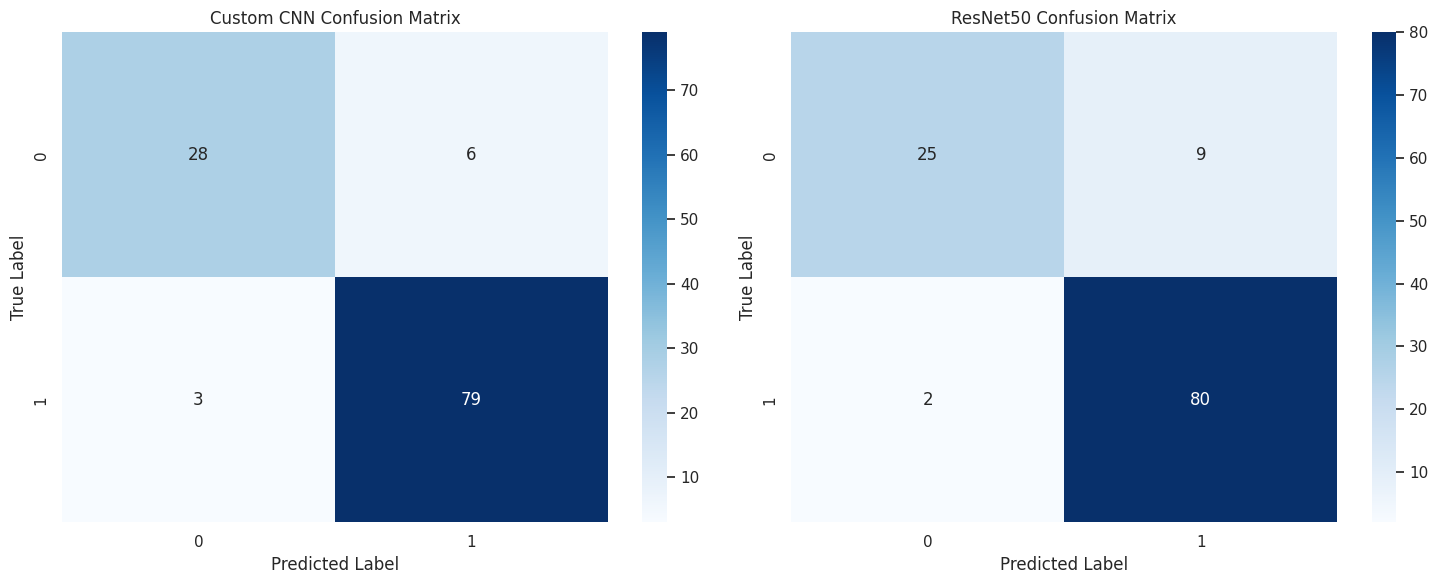


Plotting ROC curves...


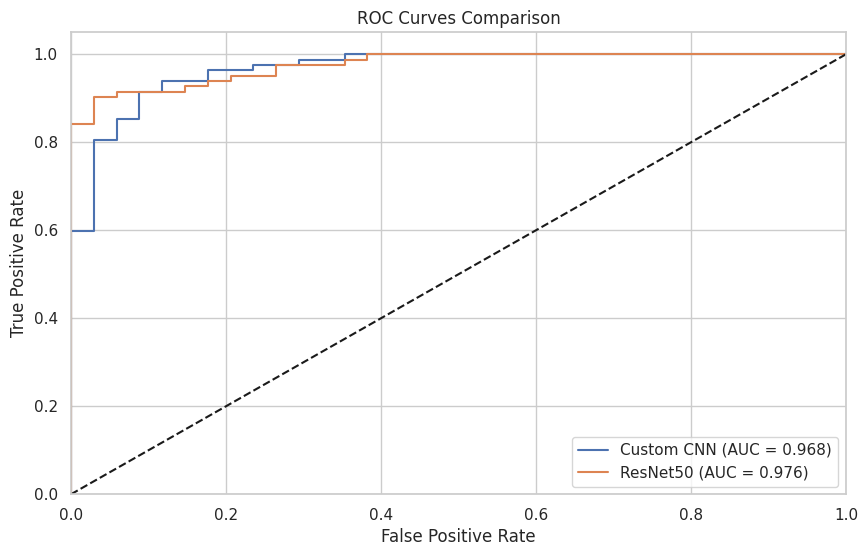


Plotting Precision-Recall curves...


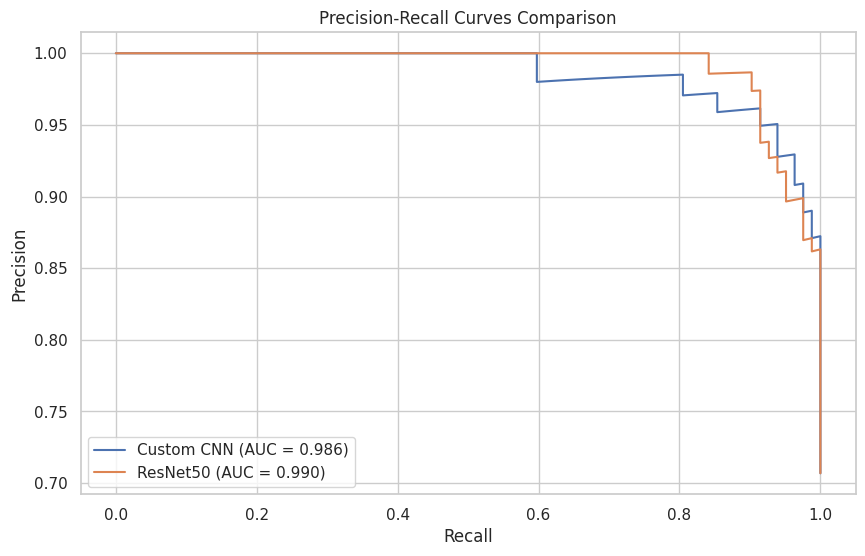


Detailed classification reports:

Custom CNN Classification Report:
              precision    recall  f1-score   support

      Normal     0.9032    0.8235    0.8615        34
   Pneumonia     0.9294    0.9634    0.9461        82

    accuracy                         0.9224       116
   macro avg     0.9163    0.8935    0.9038       116
weighted avg     0.9217    0.9224    0.9213       116


ResNet50 Classification Report:
              precision    recall  f1-score   support

      Normal     0.9259    0.7353    0.8197        34
   Pneumonia     0.8989    0.9756    0.9357        82

    accuracy                         0.9052       116
   macro avg     0.9124    0.8555    0.8777       116
weighted avg     0.9068    0.9052    0.9017       116



Evaluating Custom CNN on val:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating ResNet50 on val:   0%|          | 0/4 [00:00<?, ?it/s]

Plotting confusion matrices...


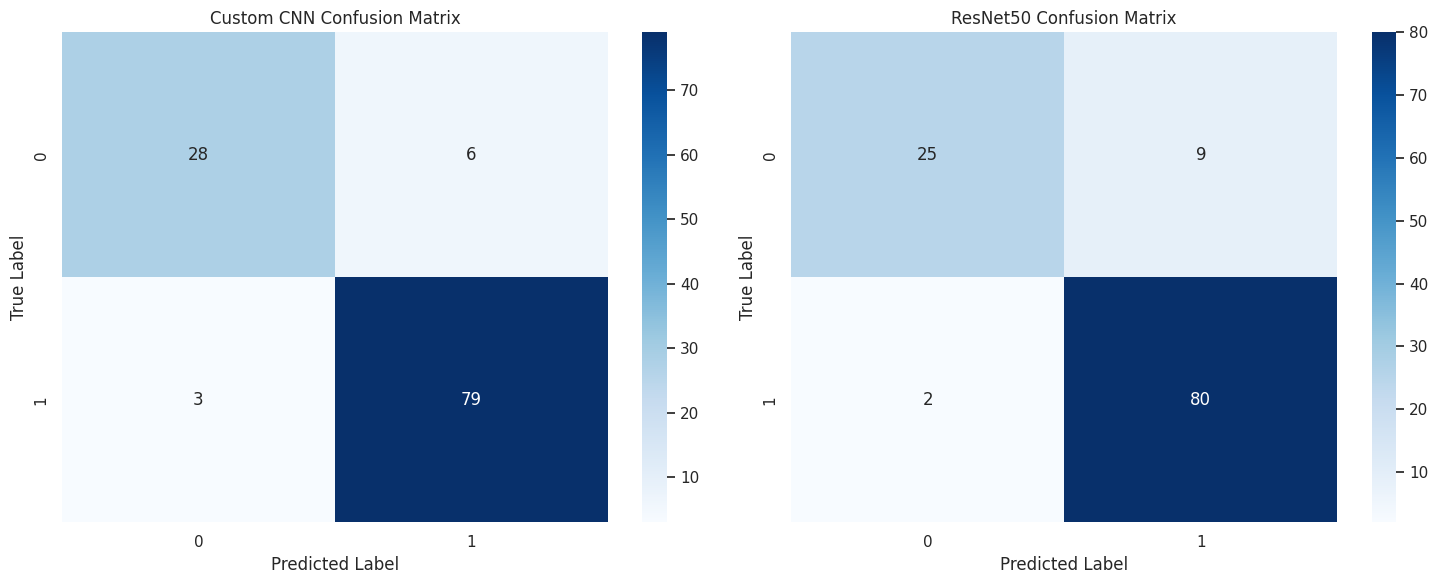


Plotting ROC curves...


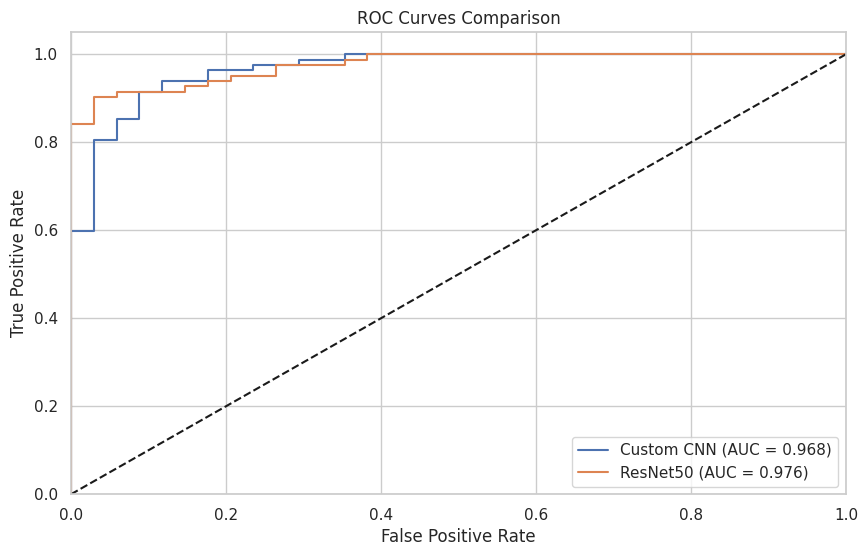


Plotting Precision-Recall curves...


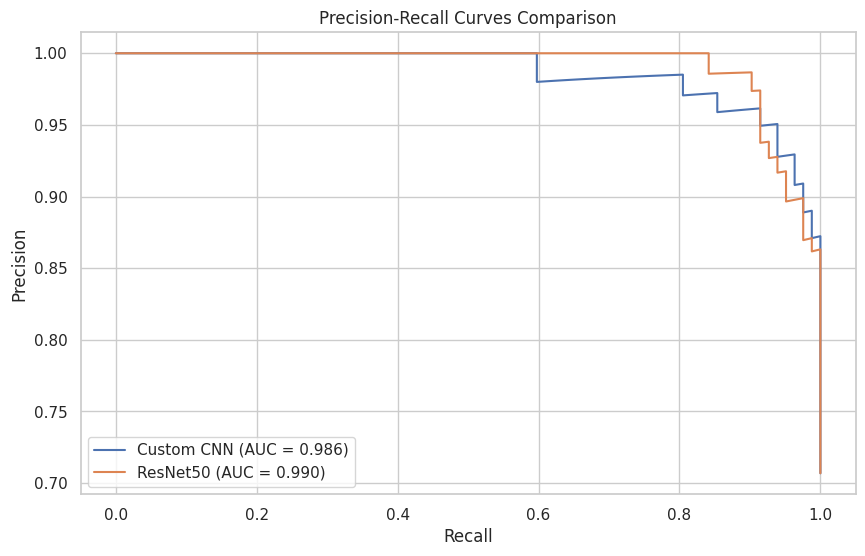


Detailed classification reports:

Custom CNN Classification Report:
              precision    recall  f1-score   support

      Normal     0.9032    0.8235    0.8615        34
   Pneumonia     0.9294    0.9634    0.9461        82

    accuracy                         0.9224       116
   macro avg     0.9163    0.8935    0.9038       116
weighted avg     0.9217    0.9224    0.9213       116


ResNet50 Classification Report:
              precision    recall  f1-score   support

      Normal     0.9259    0.7353    0.8197        34
   Pneumonia     0.8989    0.9756    0.9357        82

    accuracy                         0.9052       116
   macro avg     0.9124    0.8555    0.8777       116
weighted avg     0.9068    0.9052    0.9017       116



In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from tqdm.notebook import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader


class CompleteModelEvaluator:
    def __init__(self, models, dataloaders, device):
        """
        models: dict с моделями {'custom': model1, 'resnet': model2}
        dataloaders: dict с даталоадерами {'train': train_loader, 'val': val_loader}
        """
        self.models = models
        self.dataloaders = dataloaders
        self.device = device
        self.results = {}

    def evaluate_model(self, model_name, split='val'):
        model = self.models[model_name]
        loader = self.dataloaders[split]

        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for inputs, labels in tqdm(loader, desc=f'Evaluating {model_name} on {split}'):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())  # Вероятности для позитивного класса

        return np.array(all_labels), np.array(all_preds), np.array(all_probs)

    def plot_confusion_matrices(self, results):
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        for idx, (model_name, data) in enumerate(results.items()):
            cm = confusion_matrix(data['labels'], data['preds'])
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx], cmap='Blues')
            axes[idx].set_title(f'{model_name} Confusion Matrix')
            axes[idx].set_ylabel('True Label')
            axes[idx].set_xlabel('Predicted Label')

        plt.tight_layout()
        plt.show()

    def plot_roc_curves(self, results):
        plt.figure(figsize=(10, 6))

        for model_name, data in results.items():
            fpr, tpr, _ = roc_curve(data['labels'], data['probs'])
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend(loc="lower right")
        plt.show()

    def plot_precision_recall_curves(self, results):
        plt.figure(figsize=(10, 6))

        for model_name, data in results.items():
            precision, recall, _ = precision_recall_curve(data['labels'], data['probs'])
            pr_auc = auc(recall, precision)

            plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.3f})')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves Comparison')
        plt.legend(loc="lower left")
        plt.show()

    def print_classification_reports(self, results):
        for model_name, data in results.items():
            print(f"\n{model_name} Classification Report:")
            print(classification_report(data['labels'], data['preds'],
                                     target_names=['Normal', 'Pneumonia'],
                                     digits=4))

    def evaluate_all(self):
        results = {}

        for model_name in self.models.keys():
            labels, preds, probs = self.evaluate_model(model_name)
            results[model_name] = {
                'labels': labels,
                'preds': preds,
                'probs': probs
            }

        # Визуализация результатов
        print("Plotting confusion matrices...")
        self.plot_confusion_matrices(results)

        print("\nPlotting ROC curves...")
        self.plot_roc_curves(results)

        print("\nPlotting Precision-Recall curves...")
        self.plot_precision_recall_curves(results)

        print("\nDetailed classification reports:")
        self.print_classification_reports(results)

        return results


def load_and_evaluate_models():
    # Инициализация устройства
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device}")

    # Загрузка моделей
    custom_model = ChestXrayNet().to(device)
    resnet_model = PretrainedModel(model_name='resnet50').to(device)

    # Загрузка весов
    custom_checkpoint = torch.load('best_model_regularized.pth')
    resnet_checkpoint = torch.load('best_model_resnet.pth')

    custom_model.load_state_dict(custom_checkpoint['model_state_dict'])
    resnet_model.load_state_dict(resnet_checkpoint['model_state_dict'])

    print("Models loaded successfully")

    # Подготовка данных для валидации
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    val_dataset = ChestXrayDataset(root_dir='chest_xray', split='val', transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Инициализация evaluator'а
    evaluator = CompleteModelEvaluator(
        models={'Custom CNN': custom_model, 'ResNet50': resnet_model},
        dataloaders={'val': val_loader},
        device=device
    )

    # Запуск оценки
    print("\nStarting comprehensive evaluation...")
    results = evaluator.evaluate_all()

    return results, evaluator

# Запуск оценки
results, evaluator = load_and_evaluate_models()
results = evaluator.evaluate_all()
